# CSC413 Final Project: Movie genre classification based on plot summaries

## Table of Contents
1. [Import Libraries](#Import-Libraries)
2. [Import Data](#Import-Data)
3. [Data Preprocessing and Cleaning](#Data-Preprocessing-and-Cleaning)
4. [Model](#Model)
5. [Training and Hyperparameter Tuning](#Training-and-Hyperparameter-Tuning)
6. [Results and Ethical consideration](#Results-and-Ethical-consideration)

<a name="Import-Libraries"></a>
## 1. Import Libraries

In [ ]:
import torch.nn as nn
import torchtext
import csv
import random
import torch
import matplotlib.pyplot as plt

<a name="Import-Data"></a>
## 2. Import Data

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
#path to summary data
file_path = '/content/gdrive/My Drive/CSC413-FinalProject/MovieSummaries/plot_summaries.txt'

<a name="Data-Preprocessing-and-Cleaning"></a>
## 3. Data Preprocessing and Cleaning

In [ ]:
#regular expression to remove irrelevant info from summaries
#   e.g. {{expand section}}, hyperlinks
import re


#read the summaries from the file. Split summaries by word, so we can get wordcount.
#want to get the average word count of a movie summary.


#list of IDs and summaries. each elm is [ID, summary] form
ID_summary = []


total_words = 0 #get the total words
for line in open(file_path):

    #curr_summary is list of 2 lists. 1st list is the movie ID, 2nd list is a list of words from the plot summary.
    #curr_summary = []
    split_id = line.split('\t') #get the movie ID
    curr_ID = int(split_id[0])
    #ID_list.append([split_id[0]]) #add movie ID as 1st list in curr_summary
    plot_summary = split_id[1]
    #print(curr_summary)
    

    #now clean up plot summaries
    
    #remove {...} tags, with at least 1 occurrence of { and } each (e.g. {{expand}})
    plot_summary = re.sub('{+.*?}+', '', plot_summary) 
    #remove tags of the form <...} or <...}} (e.g. "<ref http:.....}}")
    plot_summary = re.sub('<.*?}+', '', plot_summary) 
    #remove the {{...> tags
    plot_summary = re.sub("{+.*?>", "", plot_summary) 
    #remove '{{...|...|' information (e.g. "{{plot|section|date")
    plot_summary = re.sub('{+([^ ]+ *[^ ]*\|)+[^ ]*', '', plot_summary) 
    #remove |...}} or |...}
    plot_summary = re.sub('\|.*?}+', '', plot_summary) 
    #remove '...} ' or '...}} ' info from start of summary (e.g. "December 2007}} ")
    plot_summary = re.sub('\A.*?}+(.){1}', '', plot_summary) 

    #remove "([["
    plot_summary = re.sub("\(\[\[", "", plot_summary) 
   
    #remove "{...)" and "(...}"
    plot_summary = re.sub('\(.*?}', '', plot_summary)
    plot_summary = re.sub('{.*?\)', '', plot_summary)

    #remove remaining links
    plot_summary = re.sub("http[^ ]+", '', plot_summary)

    #remove "[[.. : . |...|...>"
    # - first word after [[ is followed by :
    # - must have a | occur somewhere after the : 
    # - after that, "...|" or may not occur, where ... has no " "
    # - string may or may nor end with "...>", where ... has no " "
    # (e.g. "[[Image: hulk and thor |abc|def|hij/>")
    plot_summary = re.sub("\[\[([^ ]*?):(.*?)\|{1}(.*?\|)*((.*?)>)*", '', plot_summary)

    #remove <...> tags (e.g. <gallery> )
    plot_summary = re.sub("<(.*?)>", '', plot_summary)

    #remove periods. make whole summary one sentence
    #plot_summary = plot_summary.replace(".", " ")
    #remove ! 
    plot_summary = plot_summary.replace("!", ' ')
    #remove ?
    plot_summary = plot_summary.replace("?", ' ')
    #remove ,
    plot_summary = plot_summary.replace(",", " ")
    #remove ""
    plot_summary = plot_summary.replace('"', " ")

    




    plot_summary = plot_summary.strip() #remove leading and trailing whitespace
    plot_summary = plot_summary.lower() #make all characters lower case

    
    ID_summary.append([curr_ID, plot_summary]) 
print(ID_summary[:10])
print("Number of summaries: ",len(ID_summary))

[[23890098, "shlykov  a hard-working taxi driver and lyosha  a saxophonist  develop a bizarre love-hate relationship  and despite their prejudices  realize they aren't so different after all."], [31186339, "the nation of panem consists of a wealthy capitol and twelve poorer districts. as punishment for a past rebellion  each district must provide a boy and girl  between the ages of 12 and 18 selected by lottery  for the annual hunger games. the tributes must fight to the death in an arena; the sole survivor is rewarded with fame and wealth. in her first reaping  12-year-old primrose everdeen is chosen from district 12. her older sister katniss volunteers to take her place. peeta mellark  a baker's son who once gave katniss bread when she was starving  is the other district 12 tribute. katniss and peeta are taken to the capitol  accompanied by their frequently drunk mentor  past victor haymitch abernathy. he warns them about the  career  tributes who train intensively at special academi

In [ ]:
#total word count and avg word count after removing tags, links, etc.,
# and discarding summaries below min word count. keep summaries that are 'long' enough.
ID_summary_long = []
ID_long = [] #all the IDs of the movies we keep
min_wc = 8
total_words = 0 #get the total words
for summary in ID_summary:
    wc = len(summary[1].split())

    #track total word count
    if wc >= 8:
      ID_summary_long.append(summary)
      ID_long.append(summary[0])
      total_words += wc
    




In [ ]:

glove = torchtext.vocab.GloVe(name="6B", dim=50)

#dictionary mapping movie ID to glove indices of plot summary words
movie_ID_to_glove_idxs = {}

def get_summary_words(glove_vector):
    dataset = []
    for elm in ID_summary_long:
        plot_summary = elm[1]
        idxs = [glove_vector.stoi[w]        # lookup the index of word
                    for w in plot_summary.split()
                    #stoi is str to index. itos is index to str
                    if w in glove_vector.stoi] # keep words that has an embedding
        # ignore plot summaries without any word with an embedding
        if not idxs: 
            continue

        idxs = torch.tensor(idxs) # convert indices list to pytorch tensor
        ID = torch.tensor(elm[0]).long()
        
        
        movie_ID_to_glove_idxs[elm[0]] = idxs
        dataset.append((ID, idxs))
       
    return dataset

dataset = get_summary_words(glove)

.vector_cache/glove.6B.zip: 862MB [02:40, 5.36MB/s]                           
100%|█████████▉| 399999/400000 [00:10<00:00, 39966.61it/s]


In [ ]:


#Now look at genre information
	
metadata = []
import csv
with open("/content/gdrive/My Drive/CSC413-FinalProject/MovieSummaries/movie.metadata.tsv") as file:
    tsv_file = csv.reader(file, delimiter="\t")
    for line in tsv_file:
        metadata.append(line)
#each entry in metadata array is an array of strings representing the metadata for 1 movie


In [ ]:
#count how many genres in total, and average number of genres per movie.
#NOTE: some movies have no genres listed (genre is {} in metadata)
from collections import Counter

#converts movie ID to str genre
movie_ID_to_str_genre = {}
#dictionary to get movie title and plot from the movie ID
movie_ID_to_title_plot = {}
genres_count = Counter()

#For data preprocessing: extract the first genre listed for each movie, and the movie ID
for i in range(len(metadata)):

  
  movie_title = metadata[i][2]
  movie_wiki_id = int(metadata[i][0]) #wikipedia movie id
  
  #only get the genre if the plot summary is long enough
  if movie_wiki_id in ID_long:
  
    #genres_by_movie.append([movie_wiki_id, movie_title])
    genres_metadata = metadata[i][8]

    split_by_genre = (genres_metadata.split(',')) #this gets the genre metadata as an array of strings
    
    #genre label for current movie
    genre_label = split_by_genre[0]
      
    #need to strip movie ID and '{' '}' characters
    #Don't count movies that have no genre info (i.e. genre is {})
    if genres_metadata != "{}":
        genre_label = re.sub('.*/m/.+":', '', genre_label) #remove Freebase Movie ID
        #print("after stripping movie ID: ", genre)
        #still need to remove quotations and other characters on beginning and end of the genre
        genre_label = genre_label.strip(' ') #remove trailing and leading white spaces
        genre_label = re.sub('\A{{1}', '', genre_label) #remove leading {
        genre_label = re.sub('\A"{1}', '', genre_label) #remove leading "
        genre_label = re.sub('}{1}\Z', '', genre_label) #remove trailing } (from last genre in the list)
        genre_label = re.sub('"{1}\Z', '', genre_label) #remove trailing "


    
    
    
        movie_ID_to_title_plot[movie_wiki_id] = [movie_title]

        #add genre to our counter
        genres_count.update({genre_label: 1})

        #add the current movie's genres to the dictionary of movie_ID_to_genre
        movie_ID_to_str_genre[movie_wiki_id] = genre_label
        #genres_by_movie.append([movie_wiki_id, genre_label])

#Add the plot summaries to the movie_ID_to_title_plot dictionary
for i in range(len(ID_summary_long)):
  ID = ID_summary_long[i][0]
  if ID in tuple(movie_ID_to_title_plot.keys()):
    movie_ID_to_title_plot[ID] += [ID_summary_long[i][1]]



Get the top 10 most frequent genres as strings, store them in a list.

In [ ]:
#list of top 10 genres as string
top_genres = []

for elm in Counter(genres_count).most_common(5):
  top_genres.append(elm[0])

print(top_genres)


['Thriller', 'Drama', 'Crime Fiction', 'Short Film', 'Romantic comedy']


In [ ]:
genre_labels_stoi = {}
genre_labels_itos = {}

for str_genre in top_genres:
  #print("key: ", key, "  label: ", len(genre_labels_stoi))
  genre_labels_stoi[str_genre] = len(genre_labels_stoi)

for str_genre in genre_labels_stoi.keys():
  int_label = genre_labels_stoi[str_genre] #the int label of the genre
  genre_labels_itos[int_label] = str_genre

Make a dataset with only movies from the top 10 genres.

In [ ]:
#use genre_labels_stoi to replace the str labels in each movie genre with int.
new_dataset = []

for (movie_ID, str_genre) in movie_ID_to_str_genre.items():
  int_genre_label = 0

  #if the str_genre is not a top 10 genre, we ignore it.
  #we only add the movie to new_dataset if it is from a top 10 genre.
  if str_genre in top_genres:
    int_genre_label = torch.tensor(genre_labels_stoi[str_genre]).long()
    movie_plot = movie_ID_to_glove_idxs[movie_ID]
    new_dataset.append((int_genre_label, movie_plot, torch.tensor(movie_ID).long()))



Sort the new_dataset by genre, so movies from same genre are grouped together.


In [ ]:
#sort the new_train set by genre. so movies with same genre are grouped together
from operator import itemgetter
sorted_dataset_by_genre = sorted(new_dataset, key=itemgetter(0))
len(sorted_dataset_by_genre)
sorted_dataset_by_genre

[(tensor(0),
  tensor([   208,      6,      0,    126,    343,      3,      0,  11426,    589,
               0,    319,  11987,   6230,     19,      7,   4090,     12,     31,
              51, 245352,   2023,   3790,      4,   2385,     13,      0,   2283,
             296,   2758,    826,      0,  20303,    908,     31,    399,   1584,
           89712,     17,    266,      6,     96,   1985,      3,      0,    523,
            1284,      7,    142,    941,  17315,  20380,    126,      6,   1625,
               3,      7,    357,    145,   3067,   8279,  13647,    688,      4,
            2065,     60,      5,   1878,      7,   5031,    564,  49922,   1317,
               2,   4561,     22,      0,   3513,   3224,    328,    111,   1317,
              14,    134,    257,  20380,   3380,   3341,     64,      3,      0,
              69,     67,  11196,     12,      0,   5644,     40,   1870,     29,
            3681,  23546,    955,     21,     29,   2359,  20303,     61,      0,
   

Count of movies per genre for the sorted_dataset_by_genre (contains sorted list of movies only from top 10 genres).

In [ ]:
genres_count_top = Counter()

for movie in sorted_dataset_by_genre:
  str_genre = genre_labels_itos[movie[0].item()]
  genres_count_top.update({str_genre:1})

In [ ]:
genres_count_top

Counter({'Crime Fiction': 2928,
         'Drama': 5289,
         'Romantic comedy': 1930,
         'Short Film': 2919,
         'Thriller': 5339})

We want 900 movies from each of the top 10 genres.

In [ ]:

total_movies_processed = 0
#the number of movies we have in the current genre
movies_in_curr_genre = 0 

#the dataset with 900 movies from each top 10 genre
final_dataset = []

for i in range(5):
  #int label of the current genre we are looking at
  curr_genre_int = i
  final_dataset += sorted_dataset_by_genre[total_movies_processed:total_movies_processed+500]
  total_movies_processed += genres_count_top[genre_labels_itos[curr_genre_int]]



Check the number of movies per genre in our final dataset:



In [ ]:
genres_count_final = Counter()

for movie in final_dataset:
  str_genre = genre_labels_itos[movie[0].item()]
  genres_count_final.update({str_genre:1})
genres_count_final

Counter({'Crime Fiction': 500,
         'Drama': 500,
         'Romantic comedy': 500,
         'Short Film': 500,
         'Thriller': 500})

Now we will split the data by splitting 60% training set, 20% validation set, 20% test set. We will split like this for each genre.

In [ ]:
#split the sorted_dataset_by_genre into training, valid, and test sets
def split_data(dataset):
  train, valid, test = [], [], []

  movies_processed_so_far = 0
  total_movies_in_genre = 0

  #iterate through movie data in dataset
  for i in range(5):
      curr_genre_int = i
      curr_genre_str = genre_labels_itos[curr_genre_int]
    

      total_movies_in_genre = genres_count_final[curr_genre_str]
      #print("genre: ", curr_genre_str, "  total movies: ", total_movies_in_genre)
      training_set_size = (total_movies_in_genre * 6) // 10
      #print("training set size: ", training_set_size)

      train += dataset[movies_processed_so_far: movies_processed_so_far + training_set_size]

      movies_processed_so_far += training_set_size
      #print(movies_processed_so_far)

      #print("--------\ntotal in genre: ", total_movies_in_genre)
      #print("test set size:", training_set_size)
      valid_size = (total_movies_in_genre - training_set_size)//2
      valid += dataset[movies_processed_so_far: movies_processed_so_far + valid_size]

      movies_processed_so_far += valid_size

      #print("valid size: ", valid_size )
      test_size = total_movies_in_genre - valid_size - training_set_size
      test += dataset[movies_processed_so_far: movies_processed_so_far + test_size]
      #movies_processed_so_far += test_size
      #print("test size: ", test_size)
      movies_processed_so_far += test_size

  return train, valid, test

train, valid, test = split_data(final_dataset)

  
    

In [ ]:
print(len(train))
print(len(valid))
print(len(test))

1500
500
500


In [ ]:

#count of genres in training data 
genres_count_train = Counter()
for movie_data in train:
  genre_str = genre_labels_itos[movie_data[0].item()]
  genres_count_train.update({genre_str:1})


Make the small dataset for overfitting. We will get 2 movies from each genre.

In [ ]:



def make_small_dataset(train):
  small_dataset = []
  movies_processed_so_far = 0

  for i in range(5):
    small_dataset += train[movies_processed_so_far:movies_processed_so_far+4]
    movies_processed_so_far += genres_count_train[genre_labels_itos[i]]
  
  return small_dataset
small_dataset = make_small_dataset(train)




In [ ]:
len(small_dataset)

20

<a name="Model"></a>
## 4. Model

### 4.1 Embedding

In [ ]:
# Create an `nn.Embedding` layer and load data from pretrained `glove.vectors`
glove_emb = nn.Embedding.from_pretrained(glove.vectors)

#freeze the embedding layer weights. gradient, so they won't be updated during training
#https://androidkt.com/pre-train-word-embedding-in-pytorch/
glove_emb.weight.requires_grad = False;


### 4.2 Helper functions

In [ ]:
# Create batcher function

class SummarysBatcher:
    def __init__(self, summarys, batch_size=32, drop_last=False, shuffle=False):
        # store summarys by length
        self.summarys_by_length = {}
        for label, words, ID in summarys:
            # compute the length of the summarys
            wlen = words.shape[0]
            # put the summarys in the correct key inside self.summarys_by_length
            if wlen not in self.summarys_by_length:
                self.summarys_by_length[wlen] = []
            self.summarys_by_length[wlen].append((words, label),)
         
        #  create a DataLoader for each set of summarys of the same length
        self.loaders = {wlen : torch.utils.data.DataLoader(
                                    summarys,
                                    batch_size=batch_size,
                                    shuffle=shuffle,
                                    drop_last=drop_last) # omit last batch if smaller than batch_size
            for wlen, summarys in self.summarys_by_length.items()}
        
    def __iter__(self): # called by Python to create an iterator
        # make an iterator for every summary length
        iters = [iter(loader) for loader in self.loaders.values()]
        while iters:
            # pick an iterator (a length)
            im = random.choice(iters)
            try:
                yield next(im)
            except StopIteration:
                # no more elements in the iterator, remove it
                iters.remove(im)

In [ ]:
#train_loader
train_loader = SummarysBatcher(train, batch_size=64, drop_last=True)

#valid_loader
valid_loader = SummarysBatcher(valid, batch_size=64, drop_last=False)

#test_loader
valid_loader = SummarysBatcher(test, batch_size=64, drop_last=False)

In [ ]:
# Create get_accuracy function

def get_accuracy(model, data, batch_size):
  # note: why should we use a larger batch size here?
  loader = SummarysBatcher(data, batch_size=batch_size)

  #model.eval() # annotate model for evaluation (why do we need to do this?)

  correct = 0
  total = 0
  for text, labels in loader:
      output = model(text)
      pred = output.max(1, keepdim=True)[1]
      correct += pred.eq(labels.view_as(pred)).sum().item()
      total += text.shape[0]

  return correct/total # TODO: return the model accuracy

In [ ]:
# Create train function

def train_model(model, train_data, valid_data = None, batch_size=32, weight_decay=0.0,
           learning_rate=0.001, num_epochs=7, checkpoint_path=None):
    
  
  #training data
    loader = SummarysBatcher(train_data, batch_size=batch_size, drop_last=True, shuffle=True)
  #loss function
    criterion = nn.CrossEntropyLoss()
  #optimizer
    optimizer = torch.optim.Adam(model.parameters(),
                            lr=learning_rate,
                            weight_decay=weight_decay)
     
    epochs, losses, train_acc, valid_acc = [], [], [], []

    for epoch in range(num_epochs):
        loss = 0
        for text, labels in iter(loader):
            #print("text: ", text, "labels: ",labels)
            optimizer.zero_grad()   
            #model.train() #training
            output = model(text) #forward
            loss = criterion(output, labels)
            loss.backward() #backward
            optimizer.step()

        epochs.append(epoch)
        losses.append(float(loss))
        train_acc.append(get_accuracy(model, train_data, batch_size))
        if valid_data != None:
            valid_acc.append(get_accuracy(model, valid_data, batch_size))
            print("Epoch %d. [Loss %f] [Val Acc %.0f%%] [Train Acc %.0f%%]" % (
                epoch, loss, valid_acc[-1] * 100, train_acc[-1] * 100))
        else:
            print("Epoch %d. [Loss %f] [Train Acc %.0f%%]" % (
                epoch, loss, train_acc[-1] * 100))
       
        if checkpoint_path is not None:
            torch.save(model.state_dict(), checkpoint_path.format(epoch))

  #plotting
    plt.title("Learning Curve")
    plt.plot(epochs, losses, label="Train")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.show()

    plt.title("Learning Curve")
    plt.plot(epochs, train_acc, label="Train")
    if valid_data != None:
        plt.plot(epochs, valid_acc, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Training Accuracy")
    plt.legend(loc='best')
    plt.show()

    print("Final Training Accuracy: {}".format(train_acc[-1]*100))
    if valid_data != None:
        print("Final Validation Accuracy: {}".format(valid_acc[-1]*100))

### 4.3 Model Creation

In [ ]:
# Create Bidirectional LSTM

class BiLSTM(nn.Module):
  def __init__(self, input_size, hidden_size, num_layers, num_classes):
    super(BiLSTM, self).__init__()
    self.emb = nn.Embedding.from_pretrained(glove.vectors, freeze=False)
    self.hidden_size = hidden_size
    self.num_layers = num_layers
    self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True,
                        bidirectional=True)
    self.fc = nn.Linear(hidden_size*2, num_classes)

  def forward(self, x):
    x = self.emb(x)

    h0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)
    c0 = torch.zeros(self.num_layers*2, x.size(0), self.hidden_size)

    out, _ = self.lstm(x, (h0, c0))
    out = self.fc(out[:, -1, :])

    return out

Epoch 0. [Loss 1.236359] [Train Acc 85%]
Epoch 1. [Loss 0.048232] [Train Acc 100%]
Epoch 2. [Loss 0.010696] [Train Acc 100%]
Epoch 3. [Loss 0.011093] [Train Acc 100%]
Epoch 4. [Loss 0.031373] [Train Acc 100%]


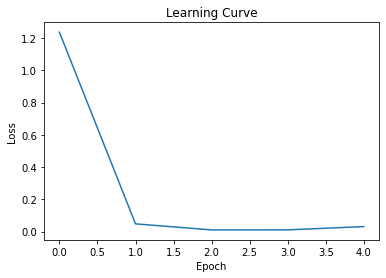

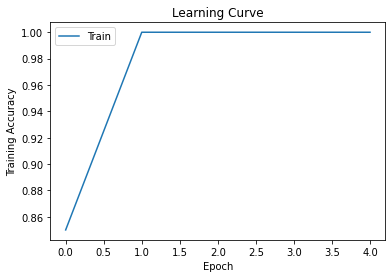

Final Training Accuracy: 100.0


In [ ]:
# Overfitting to a Small Dataset
bi = BiLSTM(input_size = 50, hidden_size = 60, num_layers = 1, num_classes = 5)
train_model(model=bi, train_data=small_dataset, batch_size=1, weight_decay=0, learning_rate=0.01, num_epochs=5, checkpoint_path="/content/gdrive/My Drive/CSC413/smalldata/ckpt-{}.pk")

<a name="Training-and-Hyperparameter-Tuning"></a>
## 5. Training and Hyperparameter Tuning

In [ ]:
print(len(train))

Epoch 0. [Loss 2.516621] [Val Acc 29%] [Train Acc 41%]
Epoch 1. [Loss 1.265344] [Val Acc 31%] [Train Acc 60%]
Epoch 2. [Loss 1.871232] [Val Acc 36%] [Train Acc 76%]
Epoch 3. [Loss 0.873533] [Val Acc 41%] [Train Acc 81%]
Epoch 4. [Loss 0.872068] [Val Acc 39%] [Train Acc 89%]
Epoch 5. [Loss 0.025353] [Val Acc 37%] [Train Acc 94%]
Epoch 6. [Loss 0.001289] [Val Acc 37%] [Train Acc 95%]
Epoch 7. [Loss 0.000000] [Val Acc 36%] [Train Acc 93%]
Epoch 8. [Loss 0.000251] [Val Acc 39%] [Train Acc 96%]
Epoch 9. [Loss 0.080971] [Val Acc 40%] [Train Acc 97%]


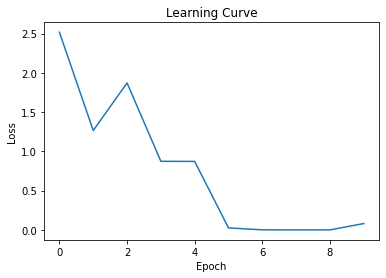

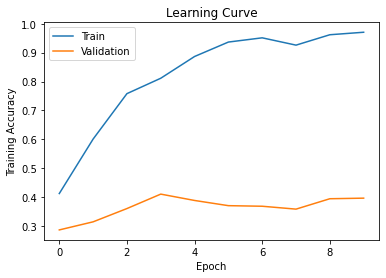

Final Training Accuracy: 97.06666666666666
Final Validation Accuracy: 39.6


In [ ]:
bi = BiLSTM(input_size = 50, hidden_size = 60, num_layers = 1, num_classes = 5)
train_model(model=bi, train_data=train, valid_data = valid,  batch_size= 1,weight_decay=0, learning_rate=0.01, num_epochs=10, checkpoint_path="/content/gdrive/My Drive/CSC413/fulltrain/ckpt-{}.pk")

<a name="Results-and-Ethical-consideration"></a>
## 6. Results and Ethical consideration

### 6.1 Test Results

In [ ]:
INCORRECT = []
CORRECT = []

def test_accuracy(model, data):
  # note: why should we use a larger batch size here?
  loader = SummarysBatcher(data, batch_size=1, shuffle=False)

  correct = 0
  total = 0
  index = 0
  for plots, labels in loader:
      output = model(plots)
      pred = output.max(1, keepdim=True)[1]
      x = pred.eq(labels.view_as(pred)).sum().item()
      if correct+x > correct:
        CORRECT.append([index, pred, labels])
      else:
        INCORRECT.append([index, pred, labels])
      correct+=x
      total += plots.shape[0]
      index+=1

  return (correct/total) # TODO: return the model accuracy

In [ ]:
bi = BiLSTM(input_size = 50, hidden_size = 60, num_layers = 1, num_classes = 5)
bi.load_state_dict(torch.load('/content/gdrive/My Drive/CSC413-FinalProject/5genre/fulltrain/ckpt-9.pk'))
print("Test accuracy for BiLSTM: " + 
      str(test_accuracy(bi, test)*100)+"%")

Test accuracy for BiLSTM: 35.0%


Correctly classified example

In [ ]:
idx = CORRECT[0][0]
MOVIE_ID = int(test[idx][2])
predicted = int(CORRECT[0][1])
label = int(CORRECT[0][2])

print("True label: " + genre_labels_itos[label])
print("Plot: ") 
print(*movie_ID_to_title_plot[int(test[idx][2])])
print("Predicted label: " + genre_labels_itos[predicted])

True label: Thriller
Plot: 
The China Syndrome while visiting the ventana nuclear power plant outside los angeles  television news reporter kimberly wells   her maverick camerman richard adams  and their soundman hector salas witness the plant going through an emergency shutdown . shift supervisor jack godell  notices an unusual vibration while grabbing his cup of coffee which he had set down; then he finds that a gauge is misreading and that the coolant is dangerously low . the crew manages to bring the reactor under control. richard surreptitiously films the incident  despite being requested to not film the control room for security purposes. when he shows the film to experts  they realize that the plant came close to the china syndrome in which the core would have melted down into the earth  hitting groundwater and contaminating the surrounding area with radioactive steam. during an inspection of the plant before it's brought back online  a technician discovers a small puddle of rad

Incorrectly classified example

In [ ]:
idx = INCORRECT[0][0]
MOVIE_ID = int(test[idx][2])
predicted = int(INCORRECT[0][1])
label = int(INCORRECT[0][2])

print("True label: " + genre_labels_itos[label])
print("Plot: ") 
print(*movie_ID_to_title_plot[int(test[idx][2])])
print("Predicted label: " + genre_labels_itos[predicted])

True label: Crime Fiction
Plot: 
The Woman Knight of Mirror Lake the film tells the story of qiu jin and her involvement in revolutionary uprisings against the qing dynasty in anhui province. influences on her life are shown through a series of flashbacks. as a child  qiu jin resisted having her feet bound according to common practice  and instead pursued her interests to learn horse riding  martial arts and literature with her father and brother. through her poetry  she expresses the her sorrow at the weak state of the nation and the repression of women. finding other like minded women in beijing and then travelling to japan to study reinforces her view that nationalist action is required to reform china. returning to china  qiu jin takes the position as xu xilin's lieutenant  assisting with the training of revolutionaries at the datong school and plotting the revolution. xu xilin is later captured while executing the assassination of the governor  and qiu jin is captured when governm